In [1]:
%cd /Users/adamsobieszek/PycharmProjects/_manipy/deixis
from __future__ import annotations
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]='1'
import torch
from typing import Any
import numpy as np
import cv2

from face_utils.facefusion.types import VisionFrame

# ---------------------------
# Internal helpers
# ---------------------------

def _as_numpy(arr: Any) -> np.ndarray:
    """
    Accepts a NumPy array or a PyTorch tensor. If it's a tensor, detach+cpu+numpy.
    """
    if isinstance(arr, np.ndarray):
        return arr
    # PyTorch-like tensor
    if hasattr(arr, "detach") and hasattr(arr, "cpu") and hasattr(arr, "numpy"):
        return arr.detach().cpu().numpy()
    raise TypeError("Expected a NumPy array or a PyTorch tensor.")

def _to_uint8_0_255(x: np.ndarray) -> np.ndarray:
    """
    Normalize to [0,255] uint8. Handles common cases:
    - [-1, 1] float -> scale
    - [0, 1] float  -> scale
    - otherwise assumes already in [0,255]
    """
    x = x.astype(np.float32, copy=False)
    vmin, vmax = float(x.min()), float(x.max())
    if vmin >= -1.01 and vmax <= 1.01:
        x = x * 127.5 + 127.5
    elif vmin >= 0.0 and vmax <= 1.0:
        x = x * 255.0
    x = np.clip(x, 0.0, 255.0)
    return x.astype(np.uint8)

def _hwc3_bgr(img: np.ndarray) -> VisionFrame:
    """
    Ensure output is HWC, 3 channels, BGR, uint8, contiguous.
    """
    if img.ndim != 3:
        raise ValueError(f"Expected 3D array (HWC or CHW), got shape {img.shape}")

    # If CHW, convert to HWC
    if img.shape[0] in (1, 3, 4) and (img.shape[2] not in (1, 3, 4)):
        img = np.transpose(img, (1, 2, 0))

    # Drop alpha if present
    if img.shape[2] == 4:
        img = img[:, :, :3]

    # If grayscale, expand to 3 channels
    if img.shape[2] == 1:
        img = cv2.cvtColor(_to_uint8_0_255(img), cv2.COLOR_GRAY2BGR)
        return np.ascontiguousarray(img, dtype=np.uint8)

    # Assume RGB → convert to BGR
    img = _to_uint8_0_255(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return np.ascontiguousarray(img, dtype=np.uint8)

# ---------------------------
# 1) From a StyleGAN generator output tensor
# ---------------------------

def visionframe_from_stylegan(tensor: Any, select: int = 0) -> VisionFrame:
    """
    Convert a StyleGAN(2) output to VisionFrame.
    Accepts:
      - torch.Tensor or np.ndarray
      - shape (C,H,W) or (N,C,H,W) or (H,W,C) or (N,H,W,C)
    Values can be in [-1,1], [0,1], or [0,255].
    """
    arr = _as_numpy(tensor)

    # Handle batch dimension
    if arr.ndim == 4:
        arr = arr[select]  # pick one sample

    if arr.ndim != 3:
        raise ValueError(f"Expected 3D tensor after batching, got shape {arr.shape}")

    return _hwc3_bgr(arr)

# ---------------------------
# 2) From a PIL.Image.Image
# ---------------------------

def visionframe_from_pil(pil_image: "Image.Image") -> VisionFrame:
    """
    Convert a PIL image to VisionFrame, respecting EXIF orientation.
    """
    try:
        from PIL import ImageOps
    except ImportError as e:
        raise ImportError("Pillow is required for visionframe_from_pil.") from e

    pil_image = ImageOps.exif_transpose(pil_image).convert("RGB")
    rgb = np.array(pil_image, dtype=np.uint8)  # HWC, RGB
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    return np.ascontiguousarray(bgr, dtype=np.uint8)

# ---------------------------
# 3) From a path to an image
# ---------------------------

def visionframe_from_path(path: str) -> VisionFrame:
    """
    Load an image from disk and return a VisionFrame (BGR, uint8).
    Uses PIL to handle EXIF orientation correctly.
    """
    try:
        from PIL import Image, ImageOps
    except ImportError as e:
        raise ImportError("Pillow is required for visionframe_from_path.") from e

    with Image.open(path) as im:
        im = ImageOps.exif_transpose(im).convert("RGB")
        rgb = np.array(im, dtype=np.uint8)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    return np.ascontiguousarray(bgr, dtype=np.uint8)

/Users/adamsobieszek/PycharmProjects/_manipy/deixis


In [2]:
from face_utils.quality_metrics import *

In [3]:
%cd /Users/adamsobieszek/PycharmProjects/_manipy/deixis

import os
import torch
import torch.nn.functional as F
from metrics.metric_utils import *

# ---------- PR helpers (from your snippet) ----------
@torch.no_grad()
def compute_distances(row_features, col_features, num_gpus, rank, col_batch_size):
    assert 0 <= rank < num_gpus
    num_cols = col_features.shape[0]
    num_batches = ((num_cols - 1) // col_batch_size // num_gpus + 1) * num_gpus
    col_batches = torch.nn.functional.pad(col_features, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
    dist_batches = []
    for col_batch in col_batches[rank :: num_gpus]:
        dist_batch = torch.cdist(row_features.unsqueeze(0), col_batch.unsqueeze(0))[0]
        for src in range(num_gpus):
            dist_broadcast = dist_batch.clone()
            if num_gpus > 1:
                torch.distributed.broadcast(dist_broadcast, src=src)
            dist_batches.append(dist_broadcast.cpu() if rank == 0 else None)
    return torch.cat(dist_batches, dim=1)[:, :num_cols] if rank == 0 else None
from types import SimpleNamespace
import torch

@torch.no_grad()
def pr_per_sample_from_dir_and_tensors(
    real_dir: str,
    gen_imgs: torch.Tensor,
    *,
    nhood_size: int = 3,
    row_batch_size: int = 512,
    col_batch_size: int = 1024,
    device: str = "cuda",
    dataset_xflip: bool = False,
    real_features=None
):
    from torch.nn import functional as F

    # --- normalize gen tensors to [-1,1]
    assert gen_imgs.ndim == 4 and gen_imgs.shape[1] == 3, "gen_imgs must be [N,3,H,W]"
    x = gen_imgs.to(torch.float32)
    if x.min().item() >= -1.01 and x.max().item() <= 1.01:
        pass
    elif x.min().item() >= 0.0 and x.max().item() <= 1.0:
        x = x * 2 - 1
    elif x.min().item() >= 0.0 and x.max().item() <= 255.0:
        x = x / 127.5 - 1.0
    else:
        raise ValueError("Unexpected gen tensor range")
    gen_imgs = x.to(device, dtype=torch.float32, non_blocking=True)

    
    progress = metric_utils.ProgressMonitor(verbose=True)

    # opts = metric_utils.MetricOptions()    # Validate arguments.
    opts = metric_utils.MetricOptions(
        device=torch.device(device),
        num_gpus=1,
        rank=0,
        cache=None,
        progress=progress,
        dataset_kwargs=dict(
            class_name="training.dataset.ImageFolderDataset",  # <-- THIS was missing
            path=real_dir,
            use_labels=False,
            xflip=dataset_xflip,
            max_size=None,
            # resolution not required; the VGG16 detector resizes internally
        ),
    )

    detector_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/vgg16.pkl"
    detector_kwargs = dict(return_features=True)

    # --- REAL features (pass batch_size explicitly)
    real_feats = (real_features if real_features is not None else compute_feature_stats_for_dataset(
        opts=opts, detector_url=detector_url, detector_kwargs=detector_kwargs,
        rel_lo=0, rel_hi=0, capture_all=True, max_items=None, batch_size=row_batch_size,
        data_loader_kwargs=dict(num_workers=0),   # macOS/MPS often safer with 0 workers
    ).get_all_torch()).to(torch.float32).to(opts.device)

    # --- GEN features via the same detector
    try:
        detector = metric_utils.get_feature_detector(detector_url, device=opts.device)
        detector.eval().requires_grad_(False)
        def run_det(b): 
            # print input kwargs
            out = detector(b, **detector_kwargs)
            return out if isinstance(out, torch.Tensor) else out[0]
    except Exception:
        def run_det(b):
            return metric_utils.compute_feature_detector_output(
                b, detector_url, detector_kwargs, device=opts.device
            )

    gen_feats_list = []
    for s in range(0, gen_imgs.shape[0], row_batch_size):
        feats = run_det(gen_imgs[s:s+row_batch_size].to(dtype=torch.float32))
        gen_feats_list.append(feats.to(torch.float32))
    gen_feats = torch.cat(gen_feats_list, dim=0).to(opts.device)

    # --- distance helpers (same as before)
    @torch.no_grad()
    def compute_distances(row_features, col_features, num_gpus, rank, col_batch_size):
        assert 0 <= rank < num_gpus
        num_cols = col_features.shape[0]
        num_batches = ((num_cols - 1) // col_batch_size // num_gpus + 1) * num_gpus
        col_batches = torch.nn.functional.pad(col_features, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
        dist_batches = []
        for col_batch in col_batches[rank :: num_gpus]:
            dist_batch = torch.cdist(row_features.unsqueeze(0), col_batch.unsqueeze(0))[0]
            for src in range(num_gpus):
                dist_broadcast = dist_batch.clone()
                if num_gpus > 1:
                    torch.distributed.broadcast(dist_broadcast, src=src)
                dist_batches.append(dist_broadcast.cpu() if rank == 0 else None)
        return torch.cat(dist_batches, dim=1)[:, :num_cols] if rank == 0 else None

    def kth_radii(manifold):
        out = []
        for mb in manifold.split(row_batch_size):
            dist = compute_distances(mb, manifold, num_gpus=opts.num_gpus, rank=opts.rank, col_batch_size=col_batch_size)
            out.append(dist.to(torch.float32).kthvalue(nhood_size + 1).values.to(torch.float32))
        return torch.cat(out, dim=0)

    kth_real = kth_radii(real_feats)
    kth_gen  = kth_radii(gen_feats)

    # precision flags for generated samples (probes = gen, manifold = real)
    prec_flags = []
    for pb in gen_feats.split(row_batch_size):
        dist = compute_distances(pb, real_feats, num_gpus=opts.num_gpus, rank=opts.rank, col_batch_size=col_batch_size)
        prec_flags.append((dist <= kth_real).any(dim=1))
    prec_flags = torch.cat(prec_flags, dim=0)

    # recall flags for real samples (probes = real, manifold = gen)
    rec_flags = []
    for pb in real_feats.split(row_batch_size):
        dist = compute_distances(pb, gen_feats, num_gpus=opts.num_gpus, rank=opts.rank, col_batch_size=col_batch_size)
        rec_flags.append((dist <= kth_gen).any(dim=1))
    rec_flags = torch.cat(rec_flags, dim=0)

    P = float(prec_flags.float().mean().item())
    R = float(rec_flags.float().mean().item())
    return prec_flags, rec_flags, P, R

import torch
from types import SimpleNamespace

def compute_feature_stats_for_dataset(opts, detector_url, detector_kwargs, rel_lo=0, rel_hi=1, batch_size=16, data_loader_kwargs=None, max_items=None, detector=None, **stats_kwargs):
    dataset = dnnlib.util.construct_class_by_name(**opts.dataset_kwargs)
    if data_loader_kwargs is None:
        data_loader_kwargs = dict(pin_memory=False, num_workers=0, prefetch_factor=None)

    # Try to lookup from cache.
    cache_file = None
    if opts.cache:
        # Choose cache file name.
        args = dict(dataset_kwargs=opts.dataset_kwargs, detector_url=detector_url, detector_kwargs=detector_kwargs, stats_kwargs=stats_kwargs)
        md5 = hashlib.md5(repr(sorted(args.items())).encode('utf-8'))
        cache_tag = f'{dataset.name}-{get_feature_detector_name(detector_url)}-{md5.hexdigest()}'
        cache_file = dnnlib.make_cache_dir_path('gan-metrics', cache_tag + '.pkl')

        # Check if the file exists (all processes must agree).
        flag = os.path.isfile(cache_file) if opts.rank == 0 else False
        if opts.num_gpus > 1:
            flag = torch.as_tensor(flag, dtype=torch.float32, device=opts.device)
            torch.distributed.broadcast(tensor=flag, src=0)
            flag = (float(flag.cpu()) != 0)

        # Load.
        if flag:
            return FeatureStats.load(cache_file)

    # Initialize.
    num_items = len(dataset)
    if max_items is not None:
        num_items = min(num_items, max_items)
    stats = FeatureStats(max_items=num_items, **stats_kwargs)
    progress = opts.progress.sub(tag='dataset features', num_items=num_items, rel_lo=rel_lo, rel_hi=rel_hi)
    
    detector = detector if detector is not None else build_feature_extractor("vgg16", device=opts.device)
    # detector = #get_feature_detector(url=detector_url, device=opts.device, num_gpus=opts.num_gpus, rank=opts.rank, verbose=progress.verbose)
    import torchvision.transforms as T
    transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
    ])

    # Main loop.
    item_subset = [(i * opts.num_gpus + opts.rank) % num_items for i in range((num_items - 1) // opts.num_gpus + 1)]
    for images, _labels in torch.utils.data.DataLoader(dataset=dataset, sampler=item_subset, batch_size=batch_size, **data_loader_kwargs):
        if images.shape[1] == 1:
            images = images.repeat([1, 3, 1, 1])
        import torchvision.transforms as T
        images = transform(images)
        if not 'features' in locals(): 
            plt.imshow(images[0].cpu().numpy().transpose(1,2,0))
            plt.show()
        mean = torch.tensor([0.485, 0.456, 0.406], device=opts.device)[None, :, None, None]
        std  = torch.tensor([0.229, 0.224, 0.225], device=opts.device)[None, :, None, None]
        images = (images.to(opts.device)/255 - mean) / std
        features = detector(images)#, **detector_kwargs)
        stats.append_torch(features, num_gpus=opts.num_gpus, rank=opts.rank)
        progress.update(stats.num_items)

    # Save to cache.
    if cache_file is not None and opts.rank == 0:
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        temp_file = cache_file + '.' + uuid.uuid4().hex
        stats.save(temp_file)
        os.replace(temp_file, cache_file) # atomic
    return stats


/Users/adamsobieszek/PycharmProjects/_manipy/deixis


In [4]:
from PIL import Image
from face_utils.facefusion_wrapper import init_facefusion_state, ensure_facefusion_models

# # 1) Initialize state like the CLI would
# init_facefusion_state(
#     detector_model="retinaface",
#     detector_size="640x640",
#     detector_score=0.75,
#     detector_angles=(0,),         # add 90/-90 if you need rotated detection
#     use_landmarker_68=True,      # set True if you want real 68-pt landmarks
#     landmarker_score=0.5,
#     download_scope="full",
# )

# # 2) Ensure models are downloaded & inference pools are ready
# ensure_facefusion_models(use_landmarker_68=True)


In [12]:
import pickle
import sys
device = torch.device('mps')

sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)
# with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:

#     D = pickle.load(fp)['D'].to(device)
# Compute the average latent vector
all_z = torch.randn([1, G.mapping.z_dim], device=device)
face_w = G.mapping(all_z, None, truncation_psi=0.5)


Using device: mps


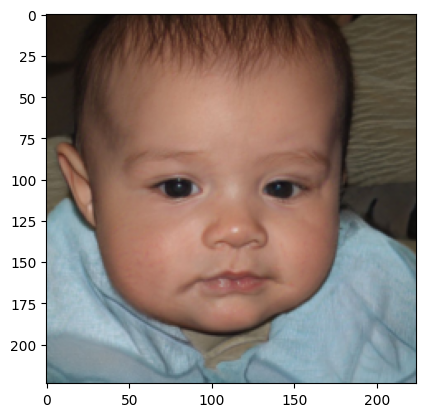

torch.Size([64, 512, 28, 28])
dataset features    items 64      time 1s           ms/item 17.48
torch.Size([64, 512]) torch.Size([64, 512])


In [6]:

import dnnlib
import matplotlib.pyplot as plt
import torch
from metrics import metric_utils

import torch
from face_utils.sg_opt.sg_output_analysis import (
    build_feature_extractor,
    CoordsToFeaturesConfig,
    coords_to_features,
    feature_sensitivity_at,
)

# 1) Pick the best available device, preferring Apple MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


#----------------------------------------------------------------------------
@torch.no_grad()
def compute_feats(opts, max_real, batch_size=32, real_features=None, extractor=None):
    detector_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/vgg16.pkl'
    detector_kwargs = dict(return_features=True,resize_images=True)

    detector = build_feature_extractor("vgg16_512", device=opts.device)
    real_features = (real_features if real_features is not None else compute_feature_stats_for_dataset(
        opts=opts, detector_url=detector_url, detector_kwargs=detector_kwargs, batch_size=batch_size,
        rel_lo=0, rel_hi=0, capture_all=True, max_items=max_real, detector=detector).get_all_torch()).to(torch.float32).to(opts.device)
    return real_features


fake_dir="/Users/adamsobieszek/PycharmProjects/_manipy/additional_age_faces_filtered_via_feature_distance/"
progress = metric_utils.ProgressMonitor(verbose=True)

# opts = metric_utils.MetricOptions()    # Validate arguments.
opts = metric_utils.MetricOptions(
    device=torch.device('mps'),
    num_gpus=1,
    rank=0,
    cache=None,
    progress=progress,
    dataset_kwargs=dict(
        class_name="training.dataset.ImageFolderDataset",  
        path=fake_dir,
        use_labels=False,
        xflip=False,
        max_size=None,
    ),
)

# real_features = compute_feats(opts, None, real_features=None, batch_size=128)
opts.dataset_kwargs['path'] = fake_dir
features = compute_feats(opts, 64, real_features=None, batch_size=128)
latents = torch.stack([torch.load(f"{fake_dir}/{f}", map_location=device)['w'] for f in sorted(os.listdir(fake_dir)) if f.endswith('.pt')])[:64]
print(features.shape, latents.shape)



In [2]:
%cd /Users/adamsobieszek/PycharmProjects/_manipy/deixis

# modern_projection.py
import math, os, numpy as np, torch
import torch.nn.functional as F
from dataclasses import dataclass
from tqdm.auto import tqdm

# your module (updated VGG to 4096 as we discussed)
from face_utils.sg_opt.sg_output_analysis import build_feature_extractor

@dataclass
class PriorBank:
    feats: torch.Tensor   # (M, 4096) float32
    coords: torch.Tensor  # (M, w_dim) float32

@torch.no_grad()
def build_prior_bank() -> PriorBank:
    """
    Samples generator to build a bank of (feature, latent) pairs for robust init.
    """
    return PriorBank(feats=features.float()[:64], coords=latents.float()[:64])

# ----------------------------
# Preprocessing & features
# ----------------------------

def preprocess_for_vgg(x_bchw: torch.Tensor, out_res: int = 224) -> torch.Tensor:
    """
    x_bchw: images in either [-1,1] (StyleGAN) or [0,1]. We auto-detect & clamp.
    Output: normalized for torchvision VGG on [0,1], resized to 224×224.
    """
    # Move to [0,1]
    if x_bchw.min() < 0.0 or x_bchw.max() > 1.0:
        x_bchw = (x_bchw + 1.0) * 0.5
    x_bchw = x_bchw.clamp(0, 1)

    # Resize to 512
    maxpool = torch.nn.AvgPool2d(kernel_size=4, stride=4)
    x_bchw = maxpool(x_bchw)

    x_bchw = x_bchw[:,:,128-112:128+112,128-112:128+112]

    # ImageNet mean/std (torchvision)
    mean = torch.tensor([0.485, 0.456, 0.406], device=x_bchw.device)[None, :, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225], device=x_bchw.device)[None, :, None, None]
    x_bchw = (x_bchw - mean) / std
    return x_bchw

def extract_features_vgg(images_bchw: torch.Tensor, extractor: torch.nn.Module) -> torch.Tensor:
    """
    images_bchw: float tensor (N,3,H,W), values in [-1,1] or [0,1]
    returns: (N, 4096) VGG fc7 embeddings
    """
    return extractor(preprocess_for_vgg(images_bchw))

# ----------------------------
# Prior bank (features & coords)
# ----------------------------


# ----------------------------
# Init from prior (soft selection)
# ----------------------------

@torch.no_grad()
def init_latents_from_prior(prior: PriorBank, target_feats: torch.Tensor,
                            w_avg: torch.Tensor, radius: float = 31.0,
                            power: float = 1.5) -> torch.Tensor:
    """
    target_feats: (N,4096)
    Returns q0: (N,w_dim) — softmin over the entire prior bank (fast & batched).
    """
    # Pairwise L2 between targets and bank
    # dist_ij = ||f_i - p_j||^2
    t2 = (target_feats ** 2).sum(dim=1, keepdim=True)              # (N,1)
    p2 = (prior.feats ** 2).sum(dim=1, keepdim=True).T             # (1,M)
    cross = target_feats @ prior.feats.T                           # (N,M)
    dists = (t2 + p2 - 2 * cross).clamp_min(0.0)                   # (N,M)

    # weights ~ softmax( (1 / dists)^power ), robust to scale
    eps = 1e-8
    inv = (1.0 / (dists + eps)) ** power                           # (N,M)
    w = torch.softmax(inv, dim=1)                                  # (N,M)

    # Weighted average in W space
    q0 = w @ prior.coords                                          # (N,w_dim)

    # Project onto sphere around w_avg to match original magnitude heuristic
    d = q0 - w_avg[None, :]
    d_norm = d.norm(dim=1, keepdim=True).clamp_min(1e-8)
    q0 = w_avg[None, :] + d * (radius / d_norm)
    return q0

# ----------------------------
# Time-weighted covariance
# ----------------------------

def time_weighted_stats(q_path_tnd: torch.Tensor, beta: float = 0.9, full_covariance: bool = False):
    """
    q_path_tnd: (T, N, D) trajectory of *EMA* latents per step.
    beta: use EMA decay to define recency weights: w_t ∝ beta^(T-1-t)
    Returns:
      mu_nd: (N,D)
      cov_nd or cov_ndd: diag (N,D) by default, or full (N,D,D) if full_covariance=True
    """
    T, N, D = q_path_tnd.shape
    device = q_path_tnd.device
    # weights newer-heavier (match EMA recency)
    t = torch.arange(T, device=device)
    w_t = (beta ** (T - 1 - t)).float()           # shape (T,)
    w_t = w_t / w_t.sum()
    w_t = w_t[:, None, None]                      # (T,1,1)

    mu = (w_t * q_path_tnd).sum(dim=0)            # (N,D)

    if not full_covariance:
        diff = q_path_tnd - mu[None, :, :]        # (T,N,D)
        var = (w_t * diff * diff).sum(dim=0)      # (N,D)
        return mu, var
    else:
        diff = q_path_tnd - mu[None, :, :]        # (T,N,D)
        # (T,N,D,1) @ (T,N,1,D) -> (T,N,D,D) then weight & sum over T
        cov = (diff.unsqueeze(-1) @ diff.unsqueeze(-2))            # (T,N,D,D)
        cov = (w_t[..., None] * cov).sum(dim=0)                    # (N,D,D)
        return mu, cov

# ----------------------------
# Batch projection loop
# ----------------------------

@dataclass
class ProjectionResult:
    q_final: torch.Tensor        # (N,w_dim) final latent (EMA)
    q_path: torch.Tensor         # (T,N,w_dim) path of EMA latents
    loss_path: torch.Tensor      # (T,N) losses per step
    mu: torch.Tensor             # (N,w_dim) time-weighted mean latent
    cov: torch.Tensor            # (N,w_dim) diag covariance (or (N,w_dim,w_dim) if requested)
    imgs_final: torch.Tensor     # (N,3,H,W) final synthesized imgs in [-1,1]
    feats_final: torch.Tensor    # (N,4096) final features
    target_feats: torch.Tensor   # (N,4096)

def project_batch(
    G,
    targets_bchw: torch.Tensor,               # (N,3,H,W) uint8 or float; if uint8, will be scaled
    *,
    device="mps",
    steps=600,
    lr=0.14,
    beta_ema=0.9,
    steps_reducelr=(5,12,27,32,39),
    extractor_name="vgg16",
    prior: PriorBank | None = None,
    truncation_psi=0.75,
    full_covariance=False,
    extractor=None,
    w0  = None
):
    """
    End-to-end, fully batched projection for many faces at once.
    """
    matplotlib.use('inline')

    device = torch.device(device)
    N = targets_bchw.shape[0]
    targets_bchw = targets_bchw.to(device)

    # If uint8, convert to float
    if targets_bchw.dtype == torch.uint8:
        targets_bchw = targets_bchw.float() / 255.0
        # targets_bchw = targets_bchw * 2.0 - 1.0   # to [-1,1] like StyleGAN

    print("Starting extraction")
    
    # Target features (batch)
    with torch.no_grad():
        target_feats = extract_features_vgg(targets_bchw, extractor)     # (N,4096)

    print("Extraction done")
    # Prior bank (build if not supplied)
    with torch.enable_grad():
        # Init from prior
        w_avg = G.mapping.w_avg.to(device)                                   # (w_dim,)
        q0 = w0.reshape(-1,512) if w0 is not None else init_latents_from_prior(prior, target_feats, w_avg, radius=31.0)  # (N,w_dim)

        # Prepare optimization variables
        q = q0.detach().clone().requires_grad_(True)                         # (N,w_dim)
        q_ema = q0.detach().clone()
        optimizer = torch.optim.AdamW([q], lr=lr, betas=(0.0, 0.999))

        # Number of styles
        num_ws = getattr(G.synthesis, "num_ws", 18)

        # Logs (store EMA)
        T = steps
        q_path = torch.empty(T, N, q.shape[1], device=device)
        loss_path = torch.empty(T, N, device=device)

        def vgg_feature_loss(imgs, tgt_feats):
            feats = extract_features_vgg(imgs, extractor)     # (N,4096)
            loss = (feats - tgt_feats).pow(2).sum(dim=1)      # scalar per sample
            return loss, feats

        # Schedule points (scaled like your original)
        schedule = {int(1.5 * s) for s in steps_reducelr}
        print("Starting optimization")
        # Optimization
        for t in tqdm(range(T), desc="Projecting (batched)"):
            optimizer.zero_grad(set_to_none=True)

            # Broadcast q to all synthesis layers
            w = q.unsqueeze(1).expand(-1, num_ws, -1)         # (N,num_ws,w_dim)
            imgs = G.synthesis(w, noise_mode='const')         # [-1,1]

            loss_vec, _ = vgg_feature_loss(imgs, target_feats)  # (N,)
            loss = loss_vec.mean()
            loss.backward()
            optimizer.step()

            # EMA
            q_ema = q_ema * beta_ema + q.detach() * (1.0 - beta_ema)

            # LR schedule
            if t in schedule:
                for pg in optimizer.param_groups:
                    pg['lr'] *= 0.5

            # Logs
            q_path[t] = q_ema
            loss_path[t] = loss_vec.detach()
            if t % 20 == 0:
                # Detach, move to cpu, clamp, and convert to uint8 for display
                im1 = imgs[0].detach().cpu()
                im2 = imgs[1].detach().cpu()
                # Assume imgs are in [-1,1], convert to [0,1]
                im1 = (im1 * 0.5 + 0.5).clamp(0, 1)
                im2 = (im2 * 0.5 + 0.5).clamp(0, 1)
                # Convert to numpy and HWC
                im1 = im1.permute(1, 2, 0).numpy()
                im2 = im2.permute(1, 2, 0).numpy()
                # Display with matplotlib (expects RGB in [0,1])
                fig, axs = plt.subplots(1, 2, figsize=(8, 4))
                axs[0].imshow(im1)
                axs[0].set_title('img1')
                axs[0].axis('off')
                axs[1].imshow(im2)
                axs[1].set_title('img2')
                axs[1].axis('off')
                plt.tight_layout()
                plt.show()
                

        # Final pass & stats
        with torch.no_grad():
            w_final = q_ema.unsqueeze(1).expand(-1, num_ws, -1)
            imgs_final = G.synthesis(w_final, noise_mode='const')
            feats_final = extract_features_vgg(imgs_final, extractor)

            mu, cov = time_weighted_stats(q_path, beta=beta_ema, full_covariance=full_covariance)
            

        return ProjectionResult(
            q_final=q_ema.detach(),
            q_path=q_path.detach(),
            loss_path=loss_path.detach(),
            mu=mu.detach(),
            cov=cov.detach(),
            imgs_final=imgs_final.detach(),
            feats_final=feats_final.detach(),
            target_feats=target_feats.detach(),
        )

/Users/adamsobieszek/PycharmProjects/_manipy/deixis


In [3]:
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
extractor = build_feature_extractor("vgg16_512", device=device)  # ensures model weights are on device

# Build a prior once (you can also pass None to let project_batch build it lazily)

# Prepare a batch of target faces (N,3,H,W) as uint8 or float in [-1,1] or [0,1]
# Example: stack a few PIL → tensor conversions, or reuse your loaded tensors:
# run_folder_projection.py
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms as T
# ----------------------------
# Configuration
# ----------------------------
FOLDER="/Users/adamsobieszek/Downloads/0.75"
SAVE_DIR = os.path.join(FOLDER, "latents")
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 2
STEPS = 600
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
def vgg_feature_loss(synth_image, target_features, perc_feat=1):
    synth_image = (synth_image + 1) * (255/2)
    if synth_image.shape[2] > 256:
        synth_image = F.interpolate(synth_image, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_image, resize_images=False, return_lpips=True)
    target_features_copy = target_features.clone()
    if perc_feat != 1:
      n = (target_features).shape[1]
      indice = random.sample(range(int(n*(1-perc_feat))-1), 1)[0]
      indice_max = indice +int(n*perc_feat)
      # indice = torch.tensor(indice)
      target_features_copy[:,indice:indice_max] -= (target_features - synth_features)[:,indice:indice_max]

    result = (target_features_copy - synth_features).square().sum(axis = 1)
    del target_features_copy
    return result
# ----------------------------
# Load generator and feature extractor
# ----------------------------
# assuming G is already loaded elsewhere (StyleGAN)
device = torch.device(DEVICE)

# ----------------------------
# Prepare image batch loader
# ----------------------------
transform = T.Compose([
    T.Resize(G.img_resolution),
    T.CenterCrop(224),
    T.ToTensor(),
    lambda x: x * 2 - 1,  # to [-1,1]
])

def load_image_tensor(path):
    img = Image.open(path).convert("RGB")
    return T.ToTensor()(img)

image_paths = sorted([
    os.path.join(FOLDER, f)
    for f in os.listdir(FOLDER)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

# ----------------------------
# Batched projection
# ----------------------------
all_names, all_q, all_mu, all_cov = [], [], [], []
for i in range(0, len(image_paths), BATCH_SIZE):
    batch_paths = image_paths[i:i+BATCH_SIZE]
    print(f"\nProcessing batch {i//BATCH_SIZE+1}: {len(batch_paths)} images")

    imgs = torch.stack([load_image_tensor(p) for p in batch_paths]).to(device)
    
    w0 = [ Image.open(p).convert("RGB")for p in batch_paths]
    w0 = [img_transforms(img).unsqueeze(0).to(device) for img in w0]
    w0 = [model(net.encoder(w)) for w in w0]
    w0 = torch.cat(w0, dim=0)
    print("Starting projection")
    result = project_batch(
        G,
        imgs,
        device=device,
        steps=STEPS//10,
        extractor_name="vgg16_512",
        full_covariance=True,
        extractor=extractor,
        w0=w0,
    )

    for name, qf, mu, cov in zip(batch_paths, result.q_final, result.mu, result.cov):
        base = os.path.splitext(os.path.basename(name))[0]
        np.save(os.path.join(SAVE_DIR, f"{base}_q_final.npy"), qf.cpu().numpy())
        np.save(os.path.join(SAVE_DIR, f"{base}_mu.npy"), mu.cpu().numpy())
        np.save(os.path.join(SAVE_DIR, f"{base}_cov.npy"), cov.cpu().numpy())
        all_names.append(base)
        all_q.append(qf.cpu().numpy())
        all_mu.append(mu.cpu().numpy()) 
        all_cov.append(cov.cpu().numpy())

# ----------------------------
# Aggregate results
# ----------------------------
np.save(os.path.join(SAVE_DIR, "all_q.npy"), np.stack(all_q))
np.save(os.path.join(SAVE_DIR, "all_mu.npy"), np.stack(all_mu))
np.save(os.path.join(SAVE_DIR, "all_cov.npy"), np.stack(all_cov))
print(f"✅ Saved {len(all_names)} projected faces to {SAVE_DIR}")

NameError: name 'G' is not defined

In [1]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
%cd /Users/adamsobieszek/PycharmProjects/_manipy/deixis/
sys.path.append("/Users/adamsobieszek/PycharmProjects/_manipy/deixis/pixel2style2pixel")
sys.path.append("/Users/adamsobieszek/PycharmProjects/_manipy/deixis/face_utils")
import pickle
import sys
device = torch.device('mps')

sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)
from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2
EXPERIMENT_ARGS= {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            # Add augmentation: inject small Gaussian noise for augmentation
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    }
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
print([*ckpt.keys()])
# opts['encoder_type'] = 'BackboneEncoderUsingLastLayerIntoW'
pprint.pprint(opts)

# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

opts['device'] = "mps"

opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.to("mps")
print('Model successfully loaded!')


image_path = '/Users/adamsobieszek/Downloads/0.75/4.jpg'
original_image = Image.open(image_path)
if opts.label_nc == 0:
    original_image = original_image.convert("RGB")
else:
    original_image = original_image.convert("L")
input_image = original_image
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def run_on_batch(inputs, net, latent_mask=None):
    if latent_mask is None:
        result_batch, latent_batch = net(inputs.to("mps").float(), randomize_noise=False, return_latents=True)
    else:
        result_batch = []
        latent_batch = []
        for image_idx, input_image in enumerate(inputs):
            # get latent vector to inject into our input image
            vec_to_inject = np.random.randn(1, 512).astype('float32')
            _, latent_to_inject = net(torch.from_numpy(vec_to_inject).to("mps"),
                                      input_code=True,
                                      return_latents=True)
            # get output image with injected style vector
            res,latents = net(input_image.unsqueeze(0).to("mps").float(),
                      latent_mask=latent_mask,
                      inject_latent=latent_to_inject, return_latents=True)
            result_batch.append(res)
            latent_batch.append(latents)
        result_batch = torch.cat(result_batch, dim=0)
        latent_batch = torch.cat(latent_batch, dim=0)
    return result_batch, latent_batch

/Users/adamsobieszek/PycharmProjects/_manipy/deixis
['state_dict', 'opts', 'latent_avg']
{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}
Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


In [3]:
import pandas as pd
df = pd.read_csv('/Users/adamsobieszek/PycharmProjects/_manipy/coords_wlosses.csv')
df.head()

,Unnamed: 0,stimulus,trustworthy,attractive,dominant,smart,age,gender,weight,typical,...,native,black,white,looks-like-you,gay,electable,godly,outdoors,dlatents,loss
0,0,1,43.673077,46.552632,79.771429,55.405405,50.404255,86.891892,38.119048,66.736842,...,13.925926,5.105263,92.970588,31.428571,20.523810,61.486486,53.439024,83.925000,"[-0.34055513, -1.9114306, -0.2459186, 0.119695...",0.170817
1,1,2,65.000000,59.750000,48.666667,57.891892,31.300000,12.560976,48.275000,49.209302,...,54.564516,72.735294,4.880952,13.465116,31.414634,66.184211,62.809524,57.513514,"[-0.77707213, -1.450018, 0.03675404, 0.2841083...",0.166311
2,2,3,37.010526,36.000000,65.428571,65.057143,51.745098,74.789474,44.790698,48.666667,...,33.898305,3.972222,68.787879,18.363636,46.024390,70.804878,55.921053,11.292683,"[-0.5631943, -0.4127729, 2.1988897, 0.5081659,...",0.142555
3,3,4,64.053191,65.500000,47.194444,54.700000,24.777778,9.526316,32.375000,44.024390,...,49.824561,72.552632,3.315789,10.500000,20.365854,57.179487,62.051282,16.560976,"[-0.9139883, 1.6725628, 0.964052, 1.1866649, -...",0.194268
4,4,5,69.577320,50.702703,56.257143,61.527778,44.534884,14.650000,40.250000,70.184211,...,10.910714,3.702703,88.842105,19.000000,21.783784,70.888889,71.833333,20.777778,"[-1.2948744, -1.5081217, -1.0790169, -0.883098...",0.183126


In [2]:
# --- Minimal W+ -> W regressor training (paste after your setup) ---
import os, glob, json, math, random, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

DATA_DIR = "/Users/adamsobieszek/PycharmProjects/_manipy/additional_age_faces_filtered_via_feature_distance"
OUT_DIR  = "/Users/adamsobieszek/PycharmProjects/_manipy/deixis/wplus2w_run_min"
os.makedirs(OUT_DIR, exist_ok=True)

def _to_w(t):
    if isinstance(t, dict) and "w" in t: t = t["w"]
    if isinstance(t, (list, tuple)): t = torch.tensor(t)
    t = t.float()
    if t.ndim == 2:  # [1,512] or [18,512]
        if t.shape[0] == 1: t = t[0]
        else: t = t.mean(0)
    assert t.shape[-1] == 512, f"bad latent shape {tuple(t.shape)}"
    return t

class WPtoWDataset(Dataset):
    def __init__(self, data_dir, cache_pairs=True):
        img_exts = ("*.jpg","*.png","*.jpeg")
        imgs = sorted([p for ext in img_exts for p in glob.glob(os.path.join(data_dir, ext))])
        self.pairs = [(p, os.path.splitext(p)[0]+".pt") for p in imgs if os.path.exists(os.path.splitext(p)[0]+".pt")]
        
        if not self.pairs: raise RuntimeError("No (image,.pt) pairs found.")
        
        self.cache_pairs = cache_pairs
        self._cache = {} if cache_pairs else None

    def __len__(self): 
        return len(self.pairs)

    @torch.no_grad()
    def __getitem__(self, i):
        if self.cache_pairs and i in self._cache:
            return self._cache[i]
        net.train()

        ipath, ppath = self.pairs[i]
        gt = torch.load(ppath, map_location="cpu")
        w_tgt = _to_w(gt)                                    # [512]
        img = Image.open(ipath).convert("RGB")
        x = img_transforms(img).unsqueeze(0).to(device)      # uses your existing transform
        latents = net.encoder(x)
        w_plus = latents[0]                   # [18,512]
        result = (w_plus, w_tgt)
        if self.cache_pairs:
            self._cache[i] = result
        return result


# w_avg from G if present, else empirical mean of dataset W+
@torch.no_grad()
def get_w_avg(ds):
    w_avg = G.mapping.w_avg.detach().view(-1)     # StyleGAN2-ADA style
    return w_avg

class WPlusToW(nn.Module):
    def __init__(self, hidden=2048):
        super().__init__()
        self.fc = nn.Linear(512, 512)
        self.weights = nn.Parameter(torch.ones(1,18,1))
        self.weights10 = nn.Parameter(torch.ones(1,10,1))
        self.alpha = nn.Parameter(torch.ones(1))
        nn.init.zeros_(self.fc.weight); nn.init.zeros_(self.fc.bias)
    def forward(self, w_plus):
        x_mean = (w_plus[:,4:-4]*self.weights10).mean(dim=1, keepdim=True)
        return (self.fc((w_plus*self.weights).mean(dim=1, keepdim=True))+x_mean*self.alpha).reshape(-1,512)/2

# --- Minimal W+ -> W regressor training (paste after your setup) ---
import os, glob, json, math, random, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

DATA_DIR = "/Users/adamsobieszek/PycharmProjects/_manipy/additional_age_faces_filtered_via_feature_distance"
OUT_DIR  = "/Users/adamsobieszek/PycharmProjects/_manipy/deixis/wplus2w_run_min"
os.makedirs(OUT_DIR, exist_ok=True)

def _to_w(t):
    if isinstance(t, dict) and "w" in t: t = t["w"]
    if isinstance(t, (list, tuple)): t = torch.tensor(t)
    t = t.float()
    if t.ndim == 2:  # [1,512] or [18,512]
        if t.shape[0] == 1: t = t[0]
        else: t = t.mean(0)
    assert t.shape[-1] == 512, f"bad latent shape {tuple(t.shape)}"
    return t

class WPtoWDatasetTodorov(Dataset):
    def __init__(self, data_dir, cache_pairs=True):

        img_exts = ("*.jpg","*.png","*.jpeg")
        imgs = sorted([p for ext in img_exts for p in glob.glob(os.path.join(data_dir, ext))])
        self.pairs = [(p, torch.tensor(eval(df.loc[df.stimulus==int(os.path.splitext(p)[0].split('/')[-1]),'dlatents'].values[0]))) for p in imgs if int(os.path.splitext(p)[0].split('/')[-1])<1005]

        if not self.pairs: raise RuntimeError("No (image,.pt) pairs found.")
        
        self.cache_pairs = cache_pairs
        self._cache = {} if cache_pairs else None

    def __len__(self): 
        return len(self.pairs)

    @torch.no_grad()
    def __getitem__(self, i):
        if self.cache_pairs and i in self._cache:
            return self._cache[i]
        net.train()

        ipath, gt = self.pairs[i]
        # gt = torch.load(ppath, map_location="cpu")
        w_tgt = _to_w(gt)                                    # [512]
        img = Image.open(ipath).convert("RGB")
        x = img_transforms(img).unsqueeze(0).to(device)      # uses your existing transform
        latents = net.encoder(x)
        w_plus = latents[0]                   # [18,512]
        result = (w_plus, w_tgt)
        if self.cache_pairs:
            self._cache[i] = result
        return result



In [3]:
# --- Minimal W+ -> W regressor training (paste after your setup) ---
import os, glob, json, math, random, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

DATA_DIR = "/Users/adamsobieszek/PycharmProjects/_manipy/additional_age_faces_filtered_via_feature_distance"
OUT_DIR  = "/Users/adamsobieszek/PycharmProjects/_manipy/deixis/wplus2w_run_min"
os.makedirs(OUT_DIR, exist_ok=True)

def _to_w(t):
    if isinstance(t, dict) and "w" in t: t = t["w"]
    if isinstance(t, (list, tuple)): t = torch.tensor(t)
    t = t.float()
    if t.ndim == 2:  # [1,512] or [18,512]
        if t.shape[0] == 1: t = t[0]
        else: t = t.mean(0)
    assert t.shape[-1] == 512, f"bad latent shape {tuple(t.shape)}"
    return t

class WPtoWDataset(Dataset):
    def __init__(self, data_dir, cache_pairs=True):
        img_exts = ("*.jpg","*.png","*.jpeg")
        imgs = sorted([p for ext in img_exts for p in glob.glob(os.path.join(data_dir, ext))])
        self.pairs = [(p, os.path.splitext(p)[0]+".pt") for p in imgs if os.path.exists(os.path.splitext(p)[0]+".pt")]
        
        if not self.pairs: raise RuntimeError("No (image,.pt) pairs found.")
        
        self.cache_pairs = cache_pairs
        self._cache = {} if cache_pairs else None

    def __len__(self): 
        return len(self.pairs)

    @torch.no_grad()
    def __getitem__(self, i):
        if self.cache_pairs and i in self._cache:
            return self._cache[i]

        ipath, ppath = self.pairs[i]
        gt = torch.load(ppath, map_location="cpu")
        w_tgt = _to_w(gt)                                    # [512]
        img = Image.open(ipath).convert("RGB")
        x = img_transforms(img).unsqueeze(0).to(device)      # uses your existing transform
        _, latents = net(x, randomize_noise=False, return_latents=True)
        w_plus = latents[0].detach().cpu()                   # [18,512]
        result = (w_plus, w_tgt)
        if self.cache_pairs:
            self._cache[i] = result
        return result


# w_avg from G if present, else empirical mean of dataset W+
@torch.no_grad()
def get_w_avg(ds):
    w_avg = G.mapping.w_avg.detach().view(-1)     # StyleGAN2-ADA style
    return w_avg

class WPlusToW(nn.Module):
    def __init__(self, hidden=2048):
        super().__init__()
        self.fc1 = nn.Linear(18*512 + 512, hidden)
        self.fc2 = nn.Linear(hidden, 512)
        self.fc3 = nn.Linear(512, 512)
        self.ln1, self.ln2, self.act, self.drop = nn.LayerNorm(hidden), nn.LayerNorm(512), nn.GELU(), nn.Dropout(0.2)
        nn.init.zeros_(self.fc3.weight); nn.init.zeros_(self.fc3.bias)
        self.input_drop = nn.Dropout1d(0.15)
    def forward(self, w_plus, w_avg):
        w_plus = self.input_drop(w_plus)
        x = torch.cat([w_plus.flatten(1), w_avg], 1)
        x_mean = x[:,4:-1].mean(dim=1, keepdim=True)
        x = self.drop(self.act(self.ln1(self.fc1(x))))
        x = self.drop(self.act(self.ln2(self.fc2(x)+x_mean)))+x_mean
        return self.fc3(x)+(x_mean)



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast
from einops import repeat, pack, unpack
from x_transformers import Attention, FeedForward, RMSNorm
from x_transformers.x_transformers import RotaryEmbedding
import math
sys.path.append("/Users/adamsobieszek/PycharmProjects/_manipy/")
from manipy import config
from manipy.models.layers import TimestepEmbedding  # (not used here, kept for parity with your stack)

class WPlusToWTransformer(nn.Module):
    """
    Maps W+ [B,18,512] (+ optional w_avg [B,512]) -> W [B,512]
    Sequence: [registers | 18 W+ tokens | 17 delta tokens | mean_x token | w_avg token]
    - W+ residual projection
    - delta tokens are (w[i+1] - mean_x), residual-projected
    - rotary embeddings optional (applied uniformly across the whole seq)
    """
    def __init__(
        self,
        dim: int = 512,
        depth: int = 6,
        num_heads: int = 8,
        dim_head: int = 64,
        num_registers: int = 4,
        mlp_ratio: int = 4,
        dropout: float = 0.1,
        use_rotary: bool = True,
        use_flash_attention: bool = True,
        append_count: int = 17,          # strictly 17 deltas
        use_wavg_bias: bool = True,
        zero_init_output: bool = True,
    ):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.num_registers = num_registers
        self.append_count = append_count
        self.use_wavg_bias = use_wavg_bias

        # Input projections (residual style)
        self.proj_in = nn.Linear(dim, dim)
        self.delta_proj = nn.Linear(dim, dim)

        # Registers
        self.registers = nn.Parameter(torch.zeros(num_registers, dim))
        nn.init.normal_(self.registers, std=0.02)

        # Rotary embeddings
        self.rotary_emb = RotaryEmbedding(dim_head) if use_rotary else None

        # Transformer layers (x-transformers blocks)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                RMSNorm(dim),
                Attention(
                    dim=dim,
                    heads=num_heads,
                    dim_head=dim_head,
                    dropout=dropout,
                    flash=use_flash_attention,
                    gate_value_heads=True,
                    softclamp_logits=False,
                    zero_init_output=True        # better stability
                ),
                RMSNorm(dim),
                FeedForward(
                    dim=dim,
                    mult=mlp_ratio,
                    dropout=dropout,
                    glu=True
                )
            ]))

        self.final_norm = RMSNorm(dim)

        # Head: summary register -> W
        self.head = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim)
        )
        if zero_init_output:
            nn.init.zeros_(self.head[-1].weight)
            nn.init.zeros_(self.head[-1].bias)

        # lightweight affine for w_avg bias (same spirit as your version)
        self.wavg_affine = nn.Linear(dim, dim, bias=False) if use_wavg_bias else nn.Identity()

    def to_bf16(self):
        self.bfloat16()
        return self

    def forward(self, w_plus: torch.Tensor, w_avg: torch.Tensor = None) -> torch.Tensor:
        """
        w_plus: [B,18,512]
        w_avg : [B,512] or None (if provided, also appended as a token)
        returns: [B,512]
        """
        B, L, D = w_plus.shape
        assert L == 18 and D == self.dim, "w_plus must be [B,18,512]"

        # tokens: W+ (residual-projected)
        x = self.proj_in(w_plus) + w_plus                         # [B,18,512]

        # center mean over middle layers (4..13 inclusive -> 10 tokens)
        mean_x = w_plus[:, 4:-4].mean(dim=1, keepdim=True)        # [B,1,512]

        # 17 deltas: w[i+1] - mean_x (residual-projected)
        deltas = w_plus[:, 1:, :] - mean_x                        # [B,17,512]
        deltas = self.delta_proj(deltas) + deltas                 # [B,17,512]

        # optional w_avg token
        if w_avg is None:
            # if not provided, fall back to batch mean of mean_x (keeps interface simple)
            w_avg_tok = mean_x
        else:
            w_avg_tok = w_avg.reshape(-1, 1, D).expand(B,1,D)

        # assemble sequence: [registers | x | deltas | mean_x | w_avg_tok]
        registers = repeat(self.registers, 'r d -> b r d', b=B)   # [B,R,512]
        seq = torch.cat([registers, x, deltas, mean_x, w_avg_tok], dim=1)

        # rotary pos emb across full sequence (if enabled)
        rotary_pos_emb = None
        if self.rotary_emb is not None:
            rotary_pos_emb = self.rotary_emb.forward_from_seq_len(seq.shape[1])

        # encoder with autocast for speed
        with autocast(device_type=seq.device.type if seq.is_cuda else "cpu", enabled=True):
            for norm1, attn, norm2, ff in self.layers:
                h = norm1(seq)
                seq = seq + attn(h, rotary_pos_emb=rotary_pos_emb)
                h = norm2(seq)
                seq = seq + ff(h)

        seq = self.final_norm(seq)

        # use first register as summary token (CLS-like)
        summary = seq[:, 0, :]                                    # [B,512]

        # head -> raw W
        w_hat = self.head(summary)                                 # [B,512]

        # final biasing as in your newer formula
        # w_hat = (w_hat + mean_x - w_avg) / 2 + w_avg
        mean_x_vec = mean_x.squeeze(1)                             # [B,512]
        w_avg_vec = w_avg_tok.squeeze(1)                           # [B,512]
        w_hat = (w_hat + (mean_x_vec - w_avg_vec)) * 0.5 + w_avg_vec

        return w_hat

In [5]:

EXPERIMENT_ARGS= {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            # Add augmentation: inject small Gaussian noise for augmentation
            transforms.RandomAffine(degrees=0, translate=(0.01, 0.01), scale=(0.999, 1.01), shear=0.01),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.5*np.random.random() if isinstance(img, torch.Tensor) else img),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])
    }
img_transforms = EXPERIMENT_ARGS['transform']

class IMtoW(Dataset):
    def __init__(self, data_dir, cache_pairs=True, to_last_layer=False):
        img_exts = ("*.jpg","*.png","*.jpeg")
        imgs = sorted([p for ext in img_exts for p in glob.glob(os.path.join(data_dir, ext))])
        self.pairs = [(p, os.path.splitext(p)[0]+".pt") for p in imgs if os.path.exists(os.path.splitext(p)[0]+".pt")]
        
        if not self.pairs: raise RuntimeError("No (image,.pt) pairs found.")
        self.to_last_layer = to_last_layer
        self.cache_pairs = cache_pairs
        self._cache = {} if cache_pairs else None

    def __len__(self): 
        return len(self.pairs)

    @torch.no_grad()
    def __getitem__(self, i):
        if self.cache_pairs and i in self._cache:
            return self._cache[i]

        ipath, ppath = self.pairs[i]
        gt = torch.load(ppath, map_location="cpu")
        w_tgt = _to_w(gt)                                    # [512]
        img = Image.open(ipath).convert("RGB")
        x = img_transforms(img).unsqueeze(0).to(device)      # uses your existing transform

        if self.to_last_layer:
            x = net.encoder.to_last_layer(x.to(device))

        else:
            x = (x.to(device))
        result = (x[0].detach(),w_tgt)
        if self.cache_pairs:
            self._cache[i] = result
        return result

In [6]:

net = pSp(opts)
net.eval()
net.to("mps")
state= torch.load(os.path.join(OUT_DIR,"model.pt"))
model_state= state["model"]
net.encoder.load_state_dict(model_state, strict=False)

Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt


<All keys matched successfully>

In [ ]:
# hyperparams (tweak as you wish)
epochs, bs, lr, wd, cos_reg, val_split = 1280, 8, 5e-4, 1e-3, 0.1, 0.05
# FOLDER="/Users/adamsobieszek/Downloads/0.75"
# ds2 = WPtoWDatasetTodorov(FOLDER)
ds = IMtoW(DATA_DIR, to_last_layer=False, cache_pairs=False)
w_avg_vec = get_w_avg(ds)

def collate(batch):
    w_plus = torch.stack([b[0] for b in batch], 0)          # [B,18,512]
    target      = torch.stack([b[1] for b in batch], 0)          # [B,512]
    w_avg  = w_avg_vec.unsqueeze(0).repeat(w_plus.size(0),1)# [B,512]
    return w_plus, w_avg, target

from pixel2style2pixel.training.ranger import Ranger
n_val = max(1, int(len(ds)*val_split))
train_ds, val_ds = random_split(ds, [len(ds)-n_val, n_val], generator=torch.Generator().manual_seed(42))
train_ld = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=0, collate_fn=collate)
# train_ld2 = DataLoader(ds2, batch_size=bs, shuffle=True,  num_workers=0, collate_fn=collate)
val_ld   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=0, collate_fn=collate)
w_avg = G.mapping.w_avg.detach().view(-1)     # StyleGAN2-ADA style
# state= torch.load(os.path.join(OUT_DIR,"model.pt"))
# model_state= state["model"]
# model = WPlusToWTransformer().to(device)
# model.load_state_dict(model_state, strict=False)
# opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
opt = torch.optim.AdamW(net.encoder.parameters(), lr=lr, weight_decay=wd)

# opt.add_param_group({"params": net.encoder.parameters()})

t_transforms = transforms.Compose([
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
best = float("inf"); log = {"train": [], "val": []}
for ep in range(1, epochs+1):
    net.encoder.train()
    G.eval().to(device)
    # model.train()
    tr = 0.0
    # for i in range(10):
    for wplus, wavg, target in (train_ld):
        # with torch.no_grad():
        #     y = G.mapping(torch.randn(8,512).to(device),None,truncation_psi=0.85+np.random.randn()*0.05)
        #     x = G.synthesis(y, noise_mode='const').clamp(-1,1)
        #     y = y.mean(dim=1)
        #     x = t_transforms(x).to(device)      # uses your existing transform
        yhat = net.encoder.to_w(wplus)
        y = target.to(device)
        loss = F.mse_loss(yhat, y+torch.randn_like(y).to(device)*0.001) + cos_reg*(1 - F.cosine_similarity(yhat-wavg, y-wavg, dim=1).mean())
        print(loss)
        opt.zero_grad(); loss.backward(); opt.step()
        tr += loss.item()*y.size(0)
    tr /= len(train_ld.dataset); log["train"].append(tr)

    net.encoder.eval()
    va = 0.0
    with torch.no_grad():
        for wplus, wavg, target in val_ld:
            
            yhat = net.encoder.to_w(wplus)
            y = target.to(device)
            loss = F.mse_loss(yhat, y) + cos_reg*(1 - F.cosine_similarity(yhat-wavg, y-wavg, dim=1).mean())
            print(loss)
            va += loss.item()*y.size(0)
    va /= len(val_ld.dataset); log["val"].append(va)
    print(f"ep {ep:02d} | train {tr:.6f} | val {va:.6f}")
    if va < best:
        best = va
        torch.save({"model": net.encoder.state_dict(), "w_avg": w_avg_vec}, os.path.join(OUT_DIR,"model.pt"))

with open(os.path.join(OUT_DIR,"stats.json"), "w") as f: json.dump(log, f, indent=2)

# Inference helper: given w_plus [B,18,512], return predicted W [B,512]
@torch.no_grad()
def wplus_to_w(w_plus, ckpt=os.path.join(OUT_DIR,"model.pt")):
    return m(w_plus.to(device), w_avg)

tensor(0.4213, device='mps:0', grad_fn=<AddBackward0>)
tensor(1.4081, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.3192, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4171, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.3509, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.3131, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4206, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4339, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4550, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4702, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.3447, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4199, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4098, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4114, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4576, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.4171, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.2816, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.3516, device='mps:0', grad_fn=<AddBackward0>)
tensor(0.3

In [ ]:
state= torch.load(os.path.join(OUT_DIR,"model.pt"))
model_state= state["model"]
net.encoder.load_state_dict(model_state, strict=False)

In [28]:
# hyperparams (tweak as you wish)
epochs, bs, lr, wd, cos_reg, val_split = 1280, 16, 1e-4, 1e-1, 0.1, 0.05
# FOLDER="/Users/adamsobieszek/Downloads/0.75"
ds2 = WPtoWDatasetTodorov(FOLDER)
ds = WPtoWDataset(DATA_DIR)
w_avg_vec = get_w_avg(ds)

def collate(batch):
    w_plus = torch.stack([b[0] for b in batch], 0)          # [B,18,512]
    y      = torch.stack([b[1] for b in batch], 0)          # [B,512]
    w_avg  = w_avg_vec.unsqueeze(0).repeat(w_plus.size(0),1)# [B,512]
    return w_plus, w_avg, y

from pixel2style2pixel.training.ranger import Ranger
n_val = max(1, int(len(ds)*val_split))
train_ds, val_ds = random_split(ds, [len(ds)-n_val, n_val], generator=torch.Generator().manual_seed(42))
train_ld = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=0, collate_fn=collate)
train_ld2 = DataLoader(ds2, batch_size=bs, shuffle=True,  num_workers=0, collate_fn=collate)
val_ld   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=0, collate_fn=collate)
w_avg = G.mapping.w_avg.detach().view(-1)     # StyleGAN2-ADA style
# state= torch.load(os.path.join(OUT_DIR,"model.pt"))
# model_state= state["model"]
# model = WPlusToWTransformer().to(device)
# model.load_state_dict(model_state, strict=False)
opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
# opt.add_param_group({"params": net.encoder.parameters()})

t_transforms = transforms.Compose([
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
best = float("inf"); log = {"train": [], "val": []}
for ep in range(1, epochs+1):
    print(ep)
    net.encoder.eval()
    G.eval().to(device)
    model.train(); tr = 0.0
    # for i in range(10):
    for wplus, wavg, y in (train_ld):
        # with torch.no_grad():
        #     y = G.mapping(torch.randn(8,512).to(device),None,truncation_psi=0.85+np.random.randn()*0.05)
        #     x = G.synthesis(y, noise_mode='const').clamp(-1,1)
        #     y = y.mean(dim=1)
        #     x = t_transforms(x).to(device)      # uses your existing transform
        # latents = net.encoder(x)
        # w_plus = latents                   # [18,512]
        yhat = model(wplus.to(device), wavg.to(device))
        y = y.to(device)
        loss = F.mse_loss(yhat, y+torch.randn_like(y).to(device)*0.001) + cos_reg*(1 - F.cosine_similarity(yhat-wavg, y-wavg, dim=1).mean())
        print(loss)
        opt.zero_grad(); loss.backward(); opt.step()
        tr += loss.item()*y.size(0)
    tr /= len(train_ld.dataset); log["train"].append(tr)

    net.encoder.eval()
    model.eval(); va = 0.0
    with torch.no_grad():
        for wplus, wavg, y in val_ld:
            yhat = model(wplus.to(device), wavg.to(device))
            y = y.to(device)
            loss = F.mse_loss(yhat, y) + cos_reg*(1 - F.cosine_similarity(yhat-wavg, y-wavg, dim=1).mean())
            print(loss)
            va += loss.item()*y.size(0)
    va /= len(val_ld.dataset); log["val"].append(va)
    print(f"ep {ep:02d} | train {tr:.6f} | val {va:.6f}")
    if va < best:
        best = va
        torch.save({"model": model.state_dict(), "w_avg": w_avg_vec}, os.path.join(OUT_DIR,"model.pt"))

with open(os.path.join(OUT_DIR,"stats.json"), "w") as f: json.dump(log, f, indent=2)

# Inference helper: given w_plus [B,18,512], return predicted W [B,512]
@torch.no_grad()
def wplus_to_w(w_plus, ckpt=os.path.join(OUT_DIR,"model.pt")):
    return m(w_plus.to(device), w_avg)

NameError: name 'FOLDER' is not defined

In [15]:
import pickle
with open('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/face_utils/psp_encoder.pkl', 'wb') as f:
    pickle.dump((net.encoder, model), f)

NameError: name 'model' is not defined

In [ ]:
with torch.no_grad():
    # sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
    # with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    #     G = pickle.load(fp)['G_ema'].to(device)
    y = G.mapping(torch.randn(8,512).to(device),None,truncation_psi=0.85+np.random.randn()*0.05)
    x = G.synthesis(y, noise_mode='const').clamp(-1,1)

In [10]:
latent_mask = None
from tqdm import tqdm
import os
image_path = '/Users/adamsobieszek/Downloads/0.75'
photo_to_coords = {}
with torch.no_grad():

    for f in tqdm(os.listdir(image_path)):
        if f.endswith('.jpg'):
            original_image = Image.open(image_path+f"/{f}")
            if opts.label_nc == 0:
                original_image = original_image.convert("RGB")
            else:
                original_image = original_image.convert("L")
            input_image = original_image
            img_transforms = EXPERIMENT_ARGS['transform']
            transformed_image = img_transforms(input_image)
        else:
            continue
        result_image, latent = run_on_batch(transformed_image.unsqueeze(0), net, latent_mask)
        result_image = result_image[0]
        photo_to_coords[f] = latent.cpu()
        torch.save(latent.cpu(), image_path+'/latents/'+f.replace('.jpg', '.pt'))
        if '7' in f and '1' in f and '2' in f:


            input_vis_image = log_input_image(transformed_image, opts)
            output_image = tensor2im(result_image)


            res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                                    np.array(output_image.resize((256, 256)))], axis=1)
            res_image = Image.fromarray(res)
            display(res_image)

  0%|          | 6/3041 [00:01<14:17,  3.54it/s]


KeyboardInterrupt: 

In [ ]:
latent_mask = None
from tqdm import tqdm
import os
image_path = '/Users/adamsobieszek/Downloads/0.75'
photo_to_coords = {}
with torch.no_grad():

    for f in tqdm(os.listdir(image_path)):
        if f.endswith('.jpg'):
            photo_to_coords[f] = torch.load(open(f'{image_path}/latents/{f.replace("jpg","pt")}', 'rb'))
        else:
            continue

  0%|          | 0/3041 [00:00<?, ?it/s]

100%|██████████| 3041/3041 [00:01<00:00, 2630.60it/s]


In [ ]:
_photo_to_coords = photo_to_coords.copy()


with open('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/face_utils/gandalf_photo_to_coords.pkl', 'wb') as f:
    pickle.dump(_photo_to_coords, f)



array([-1.2557697e+00,  2.7928295e+00, -2.0528300e+00, -4.4783854e+00,
        3.2120305e-01,  2.1688104e+00, -2.5755823e-01,  1.3235704e+00,
       -9.1395330e-01, -1.0791427e+00,  2.6207750e+00, -2.9963312e+00,
       -5.5260593e-01,  3.1494560e+00, -3.0714793e+00,  1.0643932e+00,
       -4.1863394e-01, -7.9484880e-02, -9.6702546e-02,  2.2361882e+00,
       -2.7236156e+00,  3.3508899e+00,  3.5145554e-01, -1.0499860e+00,
        2.9706416e+00,  2.4059150e+00,  7.8562045e-01, -4.4126935e+00,
       -1.7861062e+00,  2.7547736e+00,  1.9159650e+00, -3.0993865e+00,
        4.3457546e+00, -3.6939412e-01, -2.0274934e-01, -7.2650671e-01,
       -1.2415595e+00,  2.8063400e+00, -1.1088283e+00, -7.9133630e-02,
        1.6154504e-01, -9.2298388e-01,  3.4578764e+00, -9.0970725e-01,
       -1.2618148e+00, -6.6932690e-01,  2.5945809e+00,  9.6551120e-01,
       -1.0024619e+00, -5.2460651e+00,  2.8076804e+00,  1.8372360e-01,
        4.5784059e+00,  6.8500364e-01, -1.8097000e+00, -1.5773053e+00,
      

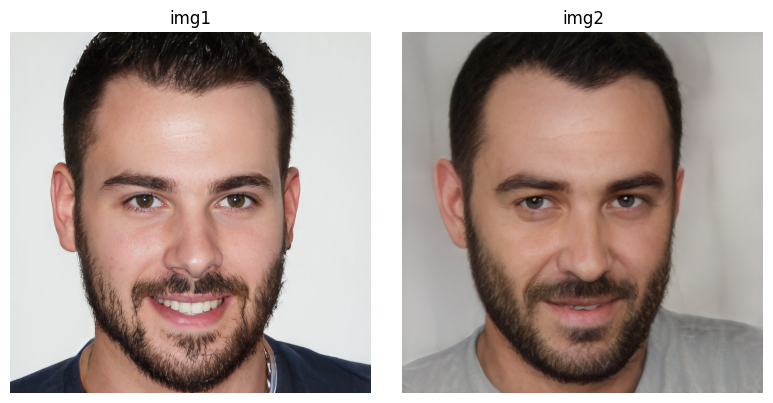

In [ ]:
latent=next(iter(photo_to_coords.values())).to("mps").reshape(1,18,512)
for i in range(1):
    yhat = model(latent.to(device)).reshape(1,1,512).expand(1,18,512)
    imgs = G.synthesis(torch.cat([yhat,latent]), noise_mode='const')         # [-1,1]

    # loss_vec, _ = vgg_feature_loss(imgs, target_feats)  # (N,)
    # loss = loss_vec.mean()
    # loss.backward()
    # optimizer.step()

    import matplotlib

    matplotlib.use('inline')

    def vgg_feature_loss(imgs, tgt_feats):
        feats = extract_features_vgg(imgs, extractor)     # (N,4096)
        loss = (feats - tgt_feats).pow(2).sum(dim=1)      # scalar per sample
        return loss, feats
    # LR schedule

    # Logs
    # Detach, move to cpu, clamp, and convert to uint8 for display
    im1 = imgs[0].detach().cpu()
    im2 =imgs[1].detach().cpu()
    # Assume imgs are in [-1,1], convert to [0,1]
    im1 = (im1 * 0.5 + 0.5).clamp(0, 1)
    im2 = (im2 * 0.5 + 0.5).clamp(0, 1)
    # Convert to numpy and HWC
    im1 = im1.permute(1, 2, 0).numpy()
    im2 = im2.permute(1, 2, 0).numpy()
    # Display with matplotlib (expects RGB in [0,1])
    # Display with matplotlib (expects RGB in [0,1])
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(im1)
    axs[0].set_title('img1')
    axs[0].axis('off')
    axs[1].imshow(im2)
    axs[1].set_title('img2')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
from dataclasses import dataclass
from typing import Dict, Literal, Optional

import matplotlib


# --- Helper dataclass --------------------------------------------------------

@dataclass
class WeightedAverageResult:
    weights: torch.Tensor      # [18] simplex weights α
    w_single: torch.Tensor     # [1, 512] weighted average ∑ α_i w_i
    img_target: torch.Tensor   # [1, 3, H, W] image from original W+
    img_recon: torch.Tensor    # [1, 3, H, W] image from repeated w_single
    losses: torch.Tensor       # [T] loss trajectory

# --- Core optimizer ----------------------------------------------------------

@torch.no_grad()
def _synth_from_wplus(G, wplus):
    """Deterministic synth from a W+ code."""
    return G.synthesis(wplus, noise_mode='const')

def _to01(x):
    # StyleGAN outputs in [-1,1]; VGG-style features typically expect [0,1]
    return (x * 0.5 + 0.5).clamp_(0, 1)

def fit_weighted_average_for_wplus(
    G,
    wplus: torch.Tensor,                        # [1, 18, 512]
    *,
    device: str = "mps",
    steps: int = 250,
    lr: float = 0.15,
    loss_type: Literal["vgg", "mse"] = "vgg",
    extractor=None,                             # pass your VGG extractor handle (same as in your code)
) -> WeightedAverageResult:
    """
    For a single W+ code, find α (softmax over 18 layers) such that
    w_single = Σ_i α_i * w_i and G(repeat(w_single)) ≈ G(wplus).
    """
    device = torch.device(device)
    wplus = wplus.to(device).detach()                  # [1, 18, 512]
    num_ws = wplus.shape[1]
    assert num_ws == getattr(G.synthesis, "num_ws", 18), "num_ws mismatch"

    # Target image and (optional) target features
    with torch.no_grad():
        img_target = _synth_from_wplus(G, wplus)      # [-1,1]
        if loss_type == "vgg":
            tgt_feats = extract_features_vgg(_to01(img_target), extractor)  # (1, 4096) in your setup

    # Optimize softmax weights on the simplex
    logits = torch.zeros(num_ws, device=device)         # uniform init
    logits[4:-4] = 1
    logits = logits.requires_grad_()
    opt = torch.optim.Adam([logits], lr=lr)
    losses = torch.zeros(steps, device=device)

    for t in range(steps):
        opt.zero_grad(set_to_none=True)

        alpha = torch.softmax(logits, dim=0)          # α_i ≥ 0, Σ α_i = 1
        # w_single = Σ_i α_i w_i
        w_single = (alpha.view(1, num_ws, 1) * wplus).sum(dim=1)            # [1, 512]
        w_broadcast = w_single.unsqueeze(1).expand(-1, num_ws, -1)          # [1, 18, 512]

        img_recon = G.synthesis(w_broadcast, noise_mode='const')            # [-1,1]

        if loss_type == "vgg":
            feats = extract_features_vgg(_to01(img_recon), extractor)
            loss = (feats - tgt_feats).pow(2).mean()
        else:
            loss = (img_recon - img_target).pow(2).mean()

        loss.backward()
        opt.step()

        losses[t] = loss.detach()

    with torch.no_grad():
        alpha = torch.softmax(logits, dim=0)
        w_single = (alpha.view(1, num_ws, 1) * wplus).sum(dim=1)            # [1, 512]
        w_broadcast = w_single.unsqueeze(1).expand(-1, num_ws, -1)
        img_recon = G.synthesis(w_broadcast, noise_mode='const')

    return WeightedAverageResult(
        weights=alpha.detach(),
        w_single=w_single.detach(),
        img_target=img_target.detach(),
        img_recon=img_recon.detach(),
        losses=losses.cpu(),
    )

# --- Batched over your dict --------------------------------------------------

def find_weighted_w_averages_for_dict(
    G,
    photo_to_coords: Dict[str, torch.Tensor],         # k -> v where v is [1,18,512]
    *,
    device: str = "mps",
    steps: int = 250,
    lr: float = 0.15,
    loss_type: Literal["vgg", "mse"] = "vgg",
    extractor=None,
) -> Dict[str, WeightedAverageResult]:
    """
    Iterate over your dict and fit weights per entry.
    """
    results: Dict[str, WeightedAverageResult] = {}
    for i, (k, v) in (enumerate(photo_to_coords.items())):
        res = fit_weighted_average_for_wplus(
            G,
            v,
            device=device,
            steps=steps,
            lr=lr,
            loss_type=loss_type,
            extractor=extractor,
        )
        results[k] = res
      
        matplotlib.use('inline')


        # Logs
        # Detach, move to cpu, clamp, and convert to uint8 for display
        im1 = res.img_recon.detach().cpu()[0]
        im2 =res.img_target.detach().cpu()[0]
        # Assume imgs are in [-1,1], convert to [0,1]
        im1 = (im1 * 0.5 + 0.5).clamp(0, 1)
        im2 = (im2 * 0.5 + 0.5).clamp(0, 1)
        
        # Convert to numpy and HWC
        im1 = im1.permute(1, 2, 0).numpy()
        im2 = im2.permute(1, 2, 0).numpy()
        # Display with matplotlib (expects RGB in [0,1])
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(im1)
        axs[0].set_title('img1')
        axs[0].axis('off')
        axs[1].imshow(im2)
        axs[1].set_title('img2')
        axs[1].axis('off')
        plt.tight_layout()
        display(fig)
        

    return results

detector = build_feature_extractor("vgg16_512", device=opts.device)
# Suppose you already have: G, photo_to_coords dict, and a VGG extractor handle
results = find_weighted_w_averages_for_dict(
    G,
    photo_to_coords,
    device="mps",
    steps=50,
    lr=0.12,
    loss_type="vgg",
    extractor=detector,
)

# Example: inspect one
name = next(iter(results))
print(name, results[name].weights, results[name].w_single.shape)

NameError: name 'photo_to_coords' is not defined

In [ ]:
%cd /Users/adamsobieszek/PycharmProjects/_manipy/deixis
import dnnlib
import matplotlib.pyplot as plt
import torch
from metrics import metric_utils

#----------------------------------------------------------------------------

@torch.no_grad()
def compute_distances(row_features, col_features, num_gpus, rank, col_batch_size):
    assert 0 <= rank < num_gpus
    num_cols = col_features.shape[0]
    num_batches = ((num_cols - 1) // col_batch_size // num_gpus + 1) * num_gpus
    col_batches = torch.nn.functional.pad(col_features, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
    dist_batches = []
    for col_batch in col_batches[rank :: num_gpus]:
        dist_batch = torch.cdist(row_features.unsqueeze(0), col_batch.unsqueeze(0))[0]
        for src in range(num_gpus):
            dist_broadcast = dist_batch.clone()
            if num_gpus > 1:
                torch.distributed.broadcast(dist_broadcast, src=src)
            dist_batches.append(dist_broadcast.cpu() if rank == 0 else None)
    return torch.cat(dist_batches, dim=1)[:, :num_cols] if rank == 0 else None

#----------------------------------------------------------------------------
@torch.no_grad()
def compute_feats(opts, max_real, batch_size=32, real_features=None, extractor=None):
    detector_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/vgg16.pkl'
    detector_kwargs = dict(return_features=True,resize_images=True)

    detector = build_feature_extractor("vgg16", device=opts.device)
    real_features = (real_features if real_features is not None else compute_feature_stats_for_dataset(
        opts=opts, detector_url=detector_url, detector_kwargs=detector_kwargs, batch_size=batch_size,
        rel_lo=0, rel_hi=0, capture_all=True, max_items=max_real, detector=detector).get_all_torch()).to(torch.float32).to(opts.device)
    return real_features



real_dir="/Users/adamsobieszek/Downloads/0.75"
fake_dir="/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_redo"
progress = metric_utils.ProgressMonitor(verbose=True)

# opts = metric_utils.MetricOptions()    # Validate arguments.
opts = metric_utils.MetricOptions(
    device=torch.device('mps'),
    num_gpus=1,
    rank=0,
    cache=None,
    progress=progress,
    dataset_kwargs=dict(
        class_name="training.dataset.ImageFolderDataset",  
        path=real_dir,
        use_labels=False,
        xflip=False,
        max_size=None,
    ),
)

# real_features = compute_feats(opts, None, real_features=None, batch_size=128)
opts.dataset_kwargs['path'] = fake_dir
fake_features = compute_feats(opts, None, real_features=None, batch_size=128)
scores, extras = realness_precision_score_from_dir_and_tensors(
    real_features=real_features,
    fake_features=fake_features,
    nhood_size=3,
    row_batch_size=4,
    col_batch_size=250,
    device='mps',  
)



print("Scores:", scores.tolist())
print("Nearest real idx:", extras["nn_index"].tolist())
print("Min ratios:", extras["min_ratio"].tolist())      # <1 means inside some radius
print("Nearest dist:", extras["nn_dist"].tolist())
print("Nearest radius:", extras["nn_radius"].tolist())

In [ ]:
dataset = dnnlib.util.construct_class_by_name(**dict(
        class_name="training.dataset.ImageFolderDataset",  
        path=fake_dir,
        use_labels=False,
        xflip=False,
        max_size=None,
    ))
dataset._image_fnames

In [ ]:
scores.shape

In [ ]:
import pandas as pd

df = pd.DataFrame({"fname":dataset._image_fnames, "scores":scores.cpu().numpy(), "scores2":scores.cpu().numpy()})
df.plot.scatter(x="scores", y="scores2", alpha=0.1)
ind= len(df)//2+100
im_path = df.sort_values(by="scores", ascending=False)["fname"].values[ind]
s = df.sort_values(by="scores", ascending=False)["scores"].values[ind]
# load and show
im = Image.open(fake_dir+'/'+im_path)
# add text
from PIL import ImageDraw
draw = ImageDraw.Draw(im)
draw.text((10, 10), f"Score: {s:.2f}", fill="red", size=4000)
im.show()


In [ ]:
import os
import shutil
base = fake_dir
# Sort by "scores" descending and get top 50%
df_sorted_scores = df.sort_values(by="scores", ascending=False)
top_50pct_scores = df_sorted_scores.head(len(df_sorted_scores) // 2)

out_dir_scores = "top50_by_scores"

os.makedirs(base+out_dir_scores, exist_ok=True)

# Copy files for top 50% by "scores"
for fname in top_50pct_scores["fname"]:
    src = base
    # If the file path is not absolute, you may need to prepend the dataset path
    if not os.path.isabs(src):
        src = os.path.join(dataset.path, src)
    if os.path.exists(src):
        shutil.copy(src+f"/{fname}", os.path.join(base+out_dir_scores, os.path.basename(fname)))

# # Sort by "scores2" descending and get top 50%
# df_sorted_scores2 = df.sort_values(by="scores2", ascending=False)
# top_50pct_scores2 = df_sorted_scores2.head(len(df_sorted_scores2) // 5)

# # Sort by "scores2" descending and get top 50%
# df['combined'] = df['scores'] + df['scores2']
# df_sorted_combined = df.sort_values(by="combined", ascending=False)
# top_50pct_combined = df_sorted_combined.head(len(df_sorted_combined) // 5)

# # Output directories
# out_dir_scores2 = "top50_by_scores2"
# out_dir_combined = "top50_by_combined"
# os.makedirs(out_dir_scores2, exist_ok=True)
# os.makedirs(out_dir_combined, exist_ok=True)

# combined
# for fname in top_50pct_combined["fname"]:
#     src = base+fname
#     if not os.path.isabs(src):
#         src = os.path.join(dataset.path, src)
#     if os.path.exists(src):
#         shutil.copy(src, os.path.join(out_dir_combined, os.path.basename(fname)))


# # Copy files for top 50% by "scores2"
# for fname in top_50pct_scores2["fname"]:
#     src = base+fname
#     if not os.path.isabs(src):
#         src = os.path.join(dataset.path, src)
#     if os.path.exists(src):
#         shutil.copy(src, os.path.join(out_dir_scores2, os.path.basename(fname)))

In [ ]:
import pickle
import sys
with open('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/face_utils/scores.pkl', 'rb') as fp:
    scores2 = pickle.load(fp)



len(scores2)

In [ ]:
c = '/Users/adamsobieszek/PycharmProjects/_manipy/additional_age_faces_filtered_via_feature_distance/'
for f in os.listdir(c):
    os.rename(c+f"{f}", c+f"{f.replace('.pt.jpg', '.jpg')}")
    # shutil.copy('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/top50_by_combined/'+f"{f}", base+out_dir_scores+f"/{f}")
    # shutil.copy('/Users/adamsobieszek/Downloads/content 2/drive/Shareddrives/[PsychGAN]/age_test_redo_additional/coords/'+f"{f.replace('.jpg', '')}", base+out_dir_scores+f"/{f.replace('.jpg', '')}")

In [ ]:
# ---------- Edge partial-face detection ----------

def _skin_mask_bgr(img_bgr: np.ndarray) -> np.ndarray:
    """Race-agnostic skin mask using YCrCb + HSV union, then cleaned."""
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    # classic YCrCb box (wide)
    m1 = (Cr >= 133) & (Cr <= 180) & (Cb >= 77) & (Cb <= 135) & (Y >= 40)

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    # wide HSV skin zone
    m2 = ((H <= 25) | (H >= 160)) & (S >= 30) & (V >= 40)

    m = (m1 | m2).astype(np.uint8) * 255
    # clean
    m = cv2.medianBlur(m, 5)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  np.ones((3,3), np.uint8))
    return m
# ---------- replace in your code ----------

def _strip_boxes(h: int, w: int, frac: float = 0.18):
    t = max(1, int(round(frac * min(h, w))))  # ensure at least 1 px
    return {
        "left":   (slice(0, h), slice(0, t)),
        "right":  (slice(0, h), slice(w - t, w)),
        "top":    (slice(0, t), slice(0, w)),
        "bottom": (slice(h - t, h), slice(0, w)),
    }

def _eye_cue(gray: np.ndarray, skin_mask: np.ndarray) -> float:
    """Return [0,1] eye-likeliness in a region (dark circle in skin)."""
    # Skip tiny/empty ROIs
    if gray.size == 0 or gray.shape[0] < 8 or gray.shape[1] < 8:
        return 0.0

    # emphasize dark blobs on skin
    g = cv2.GaussianBlur(gray, (0,0), 1.2)
    dog = cv2.Laplacian(g, cv2.CV_32F) * -1.0  # dark-on-light positive
    if skin_mask is not None and skin_mask.size == gray.size:
        dog = np.where(skin_mask.astype(bool), dog, 0.0)

    # HoughCircles needs CV_8UC1
    dog8 = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    dog8 = cv2.equalizeHist(dog8)

    h, w = gray.shape
    rmin = max(2, int(0.01 * min(h, w)))
    rmax = max(rmin + 1, int(0.04 * min(h, w)))

    circles = cv2.HoughCircles(
        dog8, cv2.HOUGH_GRADIENT, dp=1.2,
        minDist=max(4, int(0.08 * min(h, w))),
        param1=80, param2=8,
        minRadius=rmin, maxRadius=rmax
    )
    if circles is None:
        return 0.0
    c = min(3, circles.shape[1])
    return float(min(1.0, c / 2.0))

def _mouth_cue(img_bgr: np.ndarray, skin_mask: np.ndarray) -> float:
    """Return [0,1] mouth-likeliness (reddish elongated blob in skin)."""
    b,g,r = cv2.split(img_bgr.astype(np.int16))
    lipness = np.clip((r - (g+ b)//2), 0, 255).astype(np.uint8)
    lipness[skin_mask == 0] = 0
    lipness = cv2.GaussianBlur(lipness, (0,0), 1.0)
    _, th = cv2.threshold(lipness, 0, 255, cv2.THRESH_OTSU)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    cnts,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best = 0.0
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 25: 
            continue
        x,y,w,h = cv2.boundingRect(c)
        ar = w/(h+1e-6)
        if ar >= 1.4:  # elongated horizontally
            best = max(best, min(1.0, (area / (img_bgr.shape[0]*img_bgr.shape[1]))*80.0))
    return best

def _cheek_arc_cue(skin_mask: np.ndarray, border_side: str) -> float:
    """
    Look for a large skin component touching the border that fits an inward-facing ellipse arc.
    Returns [0,1].
    """
    h,w = skin_mask.shape
    # components
    cnts,_ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best = 0.0
    for c in cnts:
        if len(c) < 10: 
            continue
        area = cv2.contourArea(c)
        if area < 0.003 * h * w:
            continue
        x,y,bw,bh = cv2.boundingRect(c)
        touches = {
            "left":   x <= 1,
            "right":  x + bw >= w-2,
            "top":    y <= 1,
            "bottom": y + bh >= h-2
        }[border_side]
        if not touches:
            continue
        # fit ellipse for curvature check
        if len(c) >= 5:
            (cx, cy), (ma, mi), angle = cv2.fitEllipse(c)
            major = max(ma, mi)
            # center must be inside image and offset inward from that border
            inward = {
                "left":   cx > 0.25*major,
                "right":  (w - cx) > 0.25*major,
                "top":    cy > 0.25*major,
                "bottom": (h - cy) > 0.25*major
            }[border_side]
            if inward:
                # strength grows with area and curvature smoothness
                perim = cv2.arcLength(c, True) + 1e-6
                smooth = min(1.0, (area/perim) / 4.0)  # crude convex smoothness
                score = min(1.0, (area/(h*w))*150.0) * 0.6 + 0.4*smooth
                best = max(best, score)
    return best


def detect_partial_face_edges(img_bgr: np.ndarray, main_bbox: Optional[np.ndarray]=None,
                              debug: bool=False) -> Tuple[bool, dict]:
    """
    Return (has_partial_face, details_dict).
    Heavily biased toward catching *any* face fragment touching the image border,
    while trying to ignore neck/shoulder skin.
    """
    h, w = img_bgr.shape[:2]
    # Optionally blank out the central main face bbox so it's not counted as 'edge'
    mask_exclude = np.zeros((h,w), np.uint8)
    if main_bbox is not None:
        x1,y1,x2,y2 = np.array(main_bbox, int)
        cv2.rectangle(mask_exclude, (x1,y1), (x2,y2), 255, -1)

    strips = _strip_boxes(h, w, frac=0.18)
    skin = _skin_mask_bgr(img_bgr)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    details = {}
    fired_any = False
    for side, (ys, xs) in strips.items():
        roi_skin = skin[ys, xs].copy()
        roi_skin[mask_exclude[ys, xs] > 0] = 0  # exclude main face region if provided
        if roi_skin.sum() < 100:  # almost no skin on this edge
            details[side] = {"skin_frac": 0.0, "eye": 0.0, "mouth": 0.0, "cheek": 0.0, "score": 0.0}
            continue

        roi_bgr = img_bgr[ys, xs]
        roi_gray = gray[ys, xs]

        skin_frac = float(roi_skin.mean()/255.0)

        eye_s   = _eye_cue(roi_gray, roi_skin)
        mouth_s = _mouth_cue(roi_bgr, roi_skin)
        cheek_s = _cheek_arc_cue(roi_skin, side)

        # Combine: require skin + (eye OR mouth OR cheek_arc)
        score = (0.4*eye_s + 0.3*mouth_s + 0.3*cheek_s) * (0.5 + 0.5*skin_frac)

        # Heavy-handed thresholds:
        # - fire if strong cue OR moderate cue with lots of skin on the edge
        fire = (score >= 0.35) or (skin_frac >= 0.25 and (eye_s >= 0.25 or mouth_s >= 0.25 or cheek_s >= 0.25))

        details[side] = {
            "skin_frac": skin_frac,
            "eye": eye_s,
            "mouth": mouth_s,
            "cheek": cheek_s,
            "score": score,
            "fire": bool(fire)
        }
        fired_any |= fire

    if debug:
        print(details)
    return fired_any, details



NameError: name 'Tuple' is not defined